In [1]:
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional, SimpleRNN, GRU
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer
from keras.models import Sequential

import matplotlib.pyplot as plt
import tensorflow_addons as tfa
import tensorflow as tf
import numpy as np
import pandas as pd
import random

2022-11-30 23:58:27.272849: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-30 23:58:27.407866: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-30 23:58:27.407887: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-30 23:58:27.433745: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-30 23:58:28.108293: W tensorflow/stream_executor/platform/de

## Loading the dataset

In [2]:
chat_data = pd.read_csv("counselchat-data.csv")
chat_data = chat_data.dropna()
chat_data.head()

,questionID,questionTitle,questionText,questionUrl,topics,therapistName,therapistUrl,answerText,upvotes
0,5566fab2a64752d71ec3ca69,Escalating disagreements between mother and wife,My wife and mother are having tense disagreeme...,https://counselchat.com/questions/escalating-d...,Family Conflict,"Kristi King-Morgan, LMSW",https://counselchat.com/therapists/kristi-king...,<p>What you are describing is something psycho...,0
1,5566f94fa64752d71ec3ca64,I'm addicted to smoking. How can I stop?,"I'm planning to have baby, so I have to quit s...",https://counselchat.com/questions/i-m-addicted...,"Substance Abuse,Addiction",Rebecca Duellman,https://counselchat.com/therapists/rebecca-due...,<p>Hi. Good for you in planning ahead to do wh...,0
2,5567d26887a1cc0c3f3d8f46,Keeping secrets from my family,"I have secrets in my mind, and I don't know wh...",https://counselchat.com/questions/keeping-secr...,Family Conflict,Jeevna Bajaj,https://counselchat.com/therapists/jeevna-bajaj,<p>It sounds like keeping the secrets has beco...,0
3,556bed15c969ba5861709df5,The Underlying Causes of Being Possessive,I am extremely possessive in my relationships ...,https://counselchat.com/questions/the-underlyi...,"Behavioral Change,Social Relationships",Rebecca Duellman,https://counselchat.com/therapists/rebecca-due...,<p>Hi there. It's great you are able to realiz...,0
4,556ba115c969ba5861709de6,Can I control anxiety without medication?,I had a head injury a few years ago and my min...,https://counselchat.com/questions/can-i-contro...,Anxiety,Rebecca Duellman,https://counselchat.com/therapists/rebecca-due...,<p>You didn't say what or how many medications...,0


## Analysis

In [3]:
chat_data.shape

(1376, 9)

In [4]:
topics = chat_data['topics']
topics = list(map(lambda x: x.split(',')[0], topics))
topics

['Family Conflict',
 'Substance Abuse',
 'Family Conflict',
 'Behavioral Change',
 'Anxiety',
 'Relationship Dissolution ',
 'Anger Management',
 'Sleep Improvement',
 'Professional Ethics',
 'Social Relationships',
 'Relationships',
 'Anxiety',
 'Marriage',
 'Anxiety',
 'Family Conflict',
 'Relationships',
 'Domestic Violence',
 'Anxiety',
 'Relationships',
 'Anger Management',
 'Anxiety',
 'Military Issues ',
 'Relationships',
 'Domestic Violence',
 'Depression',
 'Marriage',
 'Grief and Loss',
 'Family Conflict',
 'Marriage',
 'Grief and Loss',
 'Trauma',
 'Relationships',
 'Relationships',
 'Relationships',
 'Anger Management',
 'Intimacy',
 'Workplace Relationships',
 'Depression',
 'Family Conflict',
 'Intimacy',
 'Human Sexuality',
 'Relationships',
 'LGBTQ',
 'Anxiety',
 'Family Conflict',
 'Domestic Violence',
 'Substance Abuse',
 'Spirituality',
 'Depression',
 'Professional Ethics',
 'Anxiety',
 'Professional Ethics',
 'Social Relationships',
 'Relationships',
 'Domestic Vio

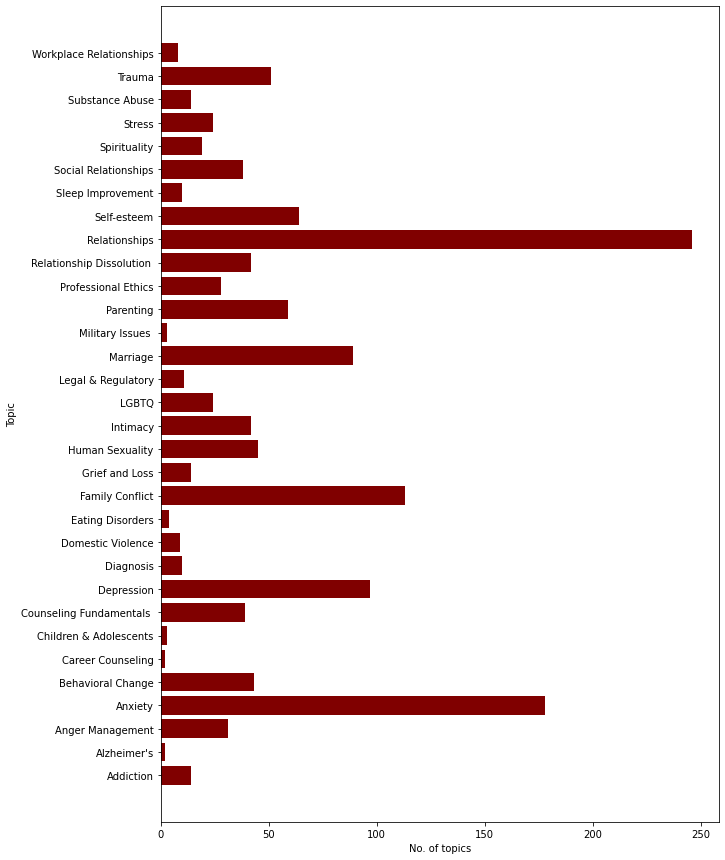

In [5]:
topic, counts = np.unique(topics, return_counts=True)

fig = plt.figure(figsize=(10, 15))

plt.barh(topic, counts, color='maroon')
plt.xlabel('No. of topics')
plt.ylabel('Topic')
plt.show()

## Filtering the dataset

In [6]:
desired_columns = ['questionTitle', 'questionText', 'answerText', 'topics']
chat_data_new = chat_data[desired_columns].copy()
chat_data_new = chat_data_new.dropna(axis = 0)
chat_data_new.tail()

,questionTitle,questionText,answerText,topics
1477,Is it healthy to embarrass a child as punishment?,My grandson's step-mother sends him to school ...,<p>Absolutely not!&nbsp;</p><p>It is never in ...,"Parenting,Family Conflict"
1478,How do I fix my relationship?,My boyfriend is in recovery from drug addictio...,<p>I'm sorry you have tension between you and ...,"Relationships,Addiction"
1479,What are the long term effects of losing one's...,The birth mother attempted suicide several tim...,"<p>The true answer is, ""no one can really say ...","Family Conflict,Parenting,Children & Adolescents"
1480,How do I help my 20 year old boyfriend who say...,I think adult life is making him depressed and...,<p>How do you help yourself to believe you req...,"Relationships,Depression,Substance Abuse"
1481,I'm worried about my new job.,I just took a job that requires me to travel f...,<p>hmm this is a tough one!</p>,"Anxiety,Career Counseling"


# Load the pre-trained BERT from transformers

In [7]:
#Load the bert tokenizer.
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [8]:
print('Vocabulary Size:', bert_tokenizer.vocab_size)

Vocabulary Size: 30522


In [9]:
#Get the embeddings from the text corpus.
def get_embeddings(sentences):
    
    tokenized_sentences = []
    embeddings = []

    for i in range(len(sentences)):
        sentences[i] = "[CLS] %s [SEP]" % (sentences[i].strip(), )
        tokenized_sentences.append(bert_tokenizer.tokenize(sentences[i]))
        embeddings.append(bert_tokenizer.convert_tokens_to_ids(tokenized_sentences[-1]))

    return embeddings

In [10]:
idx = random.randint(0, len(chat_data_new))
questionTitle = chat_data_new.loc[idx]['questionTitle']
questionText = chat_data_new.loc[idx]['questionText']

In [11]:
print('Question Title:')
print(questionTitle)
print('')
print('Question Title Embedding:')
print(get_embeddings([questionTitle]))
print('\n')

Question Title:
How can I help my fiancé accept and let go of my past?

Question Title Embedding:
[[101, 2129, 2064, 1045, 2393, 2026, 19154, 5138, 1998, 2292, 2175, 1997, 2026, 2627, 1029, 102]]




In [12]:
print('Question Text:')
print(questionText)
print('')
print('Question Text Embedding:')
print(get_embeddings([questionText]))

Question Text:
My fiancé and I come from a strong Christian background but both went off the "straight and narrow" once before. He is having a hard time accepting my past, especially  that I'm not a virgin. He has a hard time in general accepting himself and others. 

His insecurities are hurting our relationship. How can I help him let go of my past and decide to live in the present?

Question Text Embedding:
[[101, 2026, 19154, 1998, 1045, 2272, 2013, 1037, 2844, 3017, 4281, 2021, 2119, 2253, 2125, 1996, 1000, 3442, 1998, 4867, 1000, 2320, 2077, 1012, 2002, 2003, 2383, 1037, 2524, 2051, 10564, 2026, 2627, 1010, 2926, 2008, 1045, 1005, 1049, 2025, 1037, 6261, 1012, 2002, 2038, 1037, 2524, 2051, 1999, 2236, 10564, 2370, 1998, 2500, 1012, 2010, 16021, 8586, 29366, 2024, 11878, 2256, 3276, 1012, 2129, 2064, 1045, 2393, 2032, 2292, 2175, 1997, 2026, 2627, 1998, 5630, 2000, 2444, 1999, 1996, 2556, 1029, 102]]


### Map the dataset to BERT embeddings

In [13]:
def map_sentences_to_embeddings(data, column_1, column_2, max_len_1=128, max_len_2=16):
    
    sents_1 = data[column_1].tolist()
    sents_2 = data[column_2].tolist()
    entries = [str(sents_1[i] + sents_2[i]) for i in range(len(sents_1))]

    encoded_1 = get_embeddings(sents_1)
    encoded_2 = get_embeddings(sents_2)
        
    padded_1 = pad_sequences(encoded_1, padding='post', maxlen=max_len_1)
    padded_2 = pad_sequences(encoded_2, padding='post', maxlen=max_len_2)
    
    return padded_1, padded_2

In [14]:
vocab_size = bert_tokenizer.vocab_size
X, y = map_sentences_to_embeddings(chat_data_new, 'questionTitle', 'questionText')

In [15]:
X

array([[  101,  9686, 25015, ...,     0,     0,     0],
       [  101,  1045,  1005, ...,     0,     0,     0],
       [  101,  4363,  7800, ...,     0,     0,     0],
       ...,
       [  101,  2054,  2024, ...,     0,     0,     0],
       [  101,  2129,  2079, ...,     0,     0,     0],
       [  101,  1045,  1005, ...,     0,     0,     0]], dtype=int32)

In [16]:
y

array([[18185,  2003, 23848, ...,  2079,  1029,   102],
       [ 3241,  2055,  9422, ..., 13449,  1029,   102],
       [ 2079,  1029,  2009, ...,  2033,  2041,   102],
       ...,
       [ 2054,  2453,  2022, ...,  2381,  1029,   102],
       [ 2030,  2000, 15886, ...,  2032,  1029,   102],
       [ 1996,  2346,  1012, ...,  2079,  1029,   102]], dtype=int32)

## Building Bidirectional-LSTM model with 2 LSTM layers

In [17]:
metrics = ['accuracy', tf.keras.metrics.Precision()]

def bilstm_model(vocab_size, max_length, metrics):
    
    model = Sequential()
    #first Embedding layer.
    model.add(Embedding(vocab_size, 128, input_length=max_length))
    
    #first Bi-LSTM layer.
    model.add(Bidirectional(LSTM(128, return_sequences=True)))
    model.add(Dropout(0.75))
    
    #second Bi-LSTM layer.
    model.add(Bidirectional(LSTM(128)))
    model.add(Dropout(0.75))
    
    #outputllayer.
    model.add(Dense(16, activation='softmax'))
    
    model.compile(optimizer='adam', metrics=metrics, loss='categorical_crossentropy')
    
    #print model summary.
    model.summary()
    
    return model
    

2022-11-30 23:58:45.244586: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-11-30 23:58:45.244623: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-30 23:58:45.244653: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (hp): /proc/driver/nvidia/version does not exist
2022-11-30 23:58:45.246204: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [18]:
#build the model.
model = bilstm_model(vocab_size, 128, metrics)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 128, 128)          3906816   
                                                                 
 bidirectional (Bidirectiona  (None, 128, 256)         263168    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 128, 256)          0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 256)              394240    
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense (Dense)               (None, 16)                4

In [19]:
history = model.fit(X, y, epochs=15, validation_data=(X, y))

Epoch 1/15
43/43 [==============================] - 26s 525ms/step - loss: 175922.2031 - accuracy: 0.0836 - precision: 0.9814 - val_loss: 131833.5781 - val_accuracy: 0.1570 - val_precision: 0.0000e+00
Epoch 2/15
43/43 [==============================] - 21s 492ms/step - loss: 211827.4375 - accuracy: 0.0770 - precision: 0.9760 - val_loss: 137538.6250 - val_accuracy: 0.1570 - val_precision: 0.0000e+00
Epoch 3/15
43/43 [==============================] - 21s 498ms/step - loss: 218663.3438 - accuracy: 0.0814 - precision: 0.9807 - val_loss: 139024.1562 - val_accuracy: 0.1570 - val_precision: 0.0000e+00
Epoch 4/15
43/43 [==============================] - 22s 511ms/step - loss: 219947.0000 - accuracy: 0.0879 - precision: 0.9796 - val_loss: 143382.2031 - val_accuracy: 0.1570 - val_precision: 0.0000e+00
Epoch 5/15
43/43 [==============================] - 21s 485ms/step - loss: 223921.2812 - accuracy: 0.0734 - precision: 0.9885 - val_loss: 148185.9531 - val_accuracy: 0.1570 - val_precision: 0.0000

## Visualization

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

precision = history.history['precision']
val_precision = history.history['val_precision']

# precision = history.history['precision_4']
# val_precision = history.history['val_precision_4']

figure = plt.figure(figsize=(60, 90))

<Figure size 4320x6480 with 0 Axes>

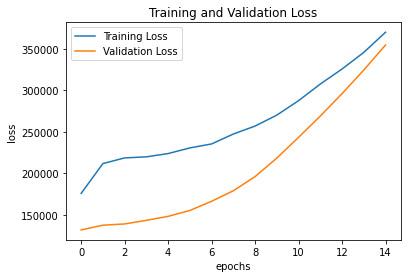

In [33]:
# Loss
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper left')
plt.title('Training and Validation Loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

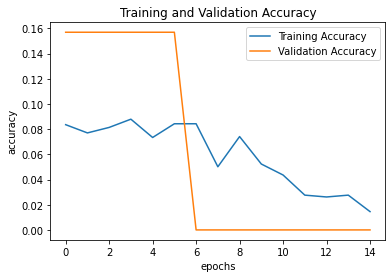

In [34]:
# Accuracy 
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='upper right')
plt.title('Training and Validation Accuracy')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.show()

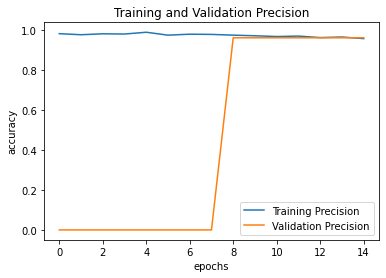

In [35]:
# Precision 
plt.plot(precision, label='Training Precision')
plt.plot(val_precision, label='Validation Precision')
plt.legend(loc='lower right')
plt.title('Training and Validation Precision')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.show()

In [36]:
topics = chat_data_new.topics.unique().tolist()

def predict_answer(query):
    seqs = get_embeddings([query])
    padded_seqs = pad_sequences(seqs, maxlen=128, padding='post')
    prediction = model.predict(padded_seqs)
    
    topic_index = np.argmax(prediction)
    
    if topic_index > len(topics):
        topic_index = len(topics) - 1
    t = topics[topic_index]
    
    upper_bound = chat_data_new.groupby('topics').get_group(t).shape[0] # .get_group(output).shape[0]
    r = np.random.randint(0,upper_bound)
    responses = list(chat_data_new.groupby('topics').get_group(t).answerText)
    print(responses[r])


### Sample query

In [37]:
query = 'The Underlying Causes of Being Possessive'

print('Given question:', query)
print('\n')
print('Answer from the mode:')
predict_answer(query)

Given question: The Underlying Causes of Being Possessive


Answer from the mode:
1/1 [==============================] - 1s 872ms/step
<p>I'm sorry you feel so alone and isolated, those feelings in and of themselves can lead to depression, stress and anxiety. &nbsp;So job one is finding someone you can talk to. &nbsp;A good friend or an open parent can be as helpful as a professional counselor, but if you don't have those, then by all means call your local Mental Health Association, suicide prevention, or go see your school counseling department. There are many of us now who do on-line, FaceTime, phone counseling so that is an option to consider in your situation. &nbsp;On the other hand, &nbsp;If you want to script a conversation with your parents (I'm a great believer in scripting) not that you're going to read it to them, but if you write down exactly what you want to say, read it over a few times before you're ready to have the conversation. &nbsp;Why? &nbsp;You'll be much more lik

## Real-time chatbot

In [39]:
while True:
    
    query = str(input('Enter your query: '))
    query = query.strip().lower()
    if query == 'quit':
        break
    
    predict_answer(query)
    

Enter your query: The Underlying Causes of Being Possessive
1/1 [==============================] - 0s 34ms/step
<p>Hi there. Being 15 years old can be a very difficult time in your teenage life. I remember when I was 15 and how I often felt my parents weren’t listening to me. It’s even more difficult when you feel that you do not have a friend that you can confide in. </p><p>Having depression in the past and being able to get through it shows me that you can get through anything! Depression alone is a very difficult problem to work through. In addition to the communication problem with your parents, it appears that you are also struggling with stress and anxiety. We all have stress and anxiety in our lives. If we didn’t, none of us would be living. Anxiety &amp; stress keep us on our toes! Often, I have to remind myself of this as well. However, it is how we manage stress and anxiety, so it will not overcome our lives. </p><p>Are you familiar with relaxation techniques, such as: deep b